# Genrating building profile with road network

In [40]:
import os
import shutil
import glob
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [57]:
# --------------------------
# Paths
# --------------------------
source_root = "data/Exp4"
train_root = "data/train"
test_root = "data/test"

# Create directories if not exist
for split in ['train', 'test']:
    for folder in ['A', 'B']:
        os.makedirs(os.path.join(f"data/{split}", folder), exist_ok=True)

# --------------------------
# Collect all image pairs
# --------------------------
pairs = []
for region in os.listdir(source_root):
    region_path = os.path.join(source_root, region)
    source_dir = os.path.join(region_path, "Source")
    target_dir = os.path.join(region_path, "Target")

    # Only process files with image extensions
    valid_exts = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
    
    for root, _, files in os.walk(source_dir):
        for file in files:
            if not any(file.lower().endswith(ext) for ext in valid_exts):
                continue  # skip non-image files
            source_path = os.path.join(root, file)
            # Construct corresponding target path
            relative_path = os.path.relpath(source_path, source_dir)
            target_path = os.path.join(target_dir, relative_path)
            if os.path.exists(target_path):
                pairs.append((region, relative_path, source_path, target_path))

# Shuffle and split
random.seed(42)
random.shuffle(pairs)
num_train = int(len(pairs) * 0.85)
train_pairs = pairs[:num_train]
test_pairs = pairs[num_train:]

# --------------------------
# Copy images and rename
# --------------------------
def copy_pair(pair_list, split_root):
    for region, rel_path, source_path, target_path in pair_list:
        parts = rel_path.split(os.sep)
        # Construct new filename to avoid conflicts: region_subfolder_filename.png
        new_name = f"{region}_{'_'.join(parts)}"
        # Destination paths
        dst_A = os.path.join(split_root, "A", new_name)
        dst_B = os.path.join(split_root, "B", new_name)

        # --------------------------
        # Copy and process input image (Source / A)
        # --------------------------
        A_img = Image.open(source_path)
        if A_img.mode in ('RGBA', 'LA'):
            background = Image.new('RGB', A_img.size, (255, 255, 255))  # white background
            if A_img.mode == 'LA':
                # LA has 2 channels (L + alpha)
                alpha = A_img.split()[1]
            else:
                alpha = A_img.split()[3]  # RGBA
            background.paste(A_img.convert('RGB'), mask=alpha)
            A_img = background
        A_img.save(dst_A)

        # --------------------------
        # Copy and process output image (Target / B)
        # --------------------------
        B_img = Image.open(target_path)
        if B_img.mode in ('RGBA', 'LA'):
            background = Image.new('RGB', B_img.size, (255, 255, 255))  # white background
            if B_img.mode == 'LA':
                alpha = B_img.split()[1]
            else:
                alpha = B_img.split()[3]
            background.paste(B_img.convert('RGB'), mask=alpha)
            B_img = background
        B_img.save(dst_B)

# Copy train and test sets
copy_pair(train_pairs, train_root)
copy_pair(test_pairs, test_root)

print(f"Train pairs: {len(train_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

Train pairs: 203
Test pairs: 36


## Data preperation

In [58]:
from PIL import Image, ImageOps
import torchvision.transforms.functional as TF

# Data argumentation
def augment_pair(image_A, image_B, flip_prob=0.5, rotate_prob=0.3, max_rotation=30, brightness=0.2, contrast=0.2):
    """
    Apply data augmentation to a pair of images (A -> input, B -> target).
    All transformations are applied **synchronously** to maintain alignment.

    Parameters:
        image_A (PIL.Image) -- input image (Source)
        image_B (PIL.Image) -- target image (Target)
        flip_prob (float)   -- probability to apply horizontal flip
        rotate_prob (float) -- probability to apply random rotation
        max_rotation (int)  -- maximum rotation degree (+/-)
        brightness (float)  -- max brightness jitter factor
        contrast (float)    -- max contrast jitter factor

    Returns:
        aug_A, aug_B (PIL.Image) -- augmented images
    """

    # --------------------------
    # Horizontal flip
    # --------------------------
    if random.random() < flip_prob:
        image_A = ImageOps.mirror(image_A)
        image_B = ImageOps.mirror(image_B)

    # --------------------------
    # Random rotation
    # --------------------------
    if random.random() < rotate_prob:
        angle = random.uniform(-max_rotation, max_rotation)
        image_A = image_A.rotate(angle, resample=Image.BILINEAR)
        image_B = image_B.rotate(angle, resample=Image.BILINEAR)

    # --------------------------
    # Brightness adjustment
    # --------------------------
    if brightness > 0:
        factor = random.uniform(1 - brightness, 1 + brightness)
        image_A = TF.adjust_brightness(image_A, factor)
        image_B = TF.adjust_brightness(image_B, factor)

    # --------------------------
    # Contrast adjustment
    # --------------------------
    if contrast > 0:
        factor = random.uniform(1 - contrast, 1 + contrast)
        image_A = TF.adjust_contrast(image_A, factor)
        image_B = TF.adjust_contrast(image_B, factor)

    return image_A, image_B

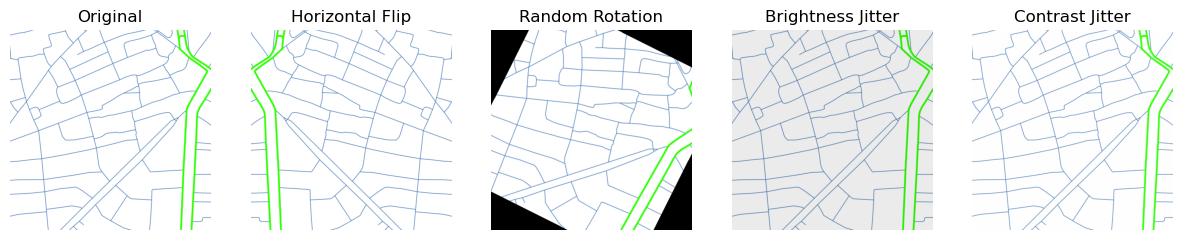

In [59]:
# Load example image
img_A = Image.open("data/train/A/Jakarta_16_52219_33892.png")
img_B = Image.open("data/train/B/Jakarta_16_52219_33892.png")

# Set random seed for reproducibility
random.seed(42)

# Prepare a list of example augmentations
examples = []

# 1. Original (no augmentation)
examples.append(("Original", img_A))

# 2. Horizontal flip only
random.seed(1)
aug_A, _ = augment_pair(img_A, img_B, flip_prob=1.0, rotate_prob=0.0, brightness=0.0, contrast=0.0)
examples.append(("Horizontal Flip", aug_A))

# 3. Random rotation only
random.seed(2)
aug_A, _ = augment_pair(img_A, img_B, flip_prob=0.0, rotate_prob=1.0, max_rotation=30, brightness=0.0, contrast=0.0)
examples.append(("Random Rotation", aug_A))

# 4. Brightness adjustment only
random.seed(3)
aug_A, _ = augment_pair(img_A, img_B, flip_prob=0.0, rotate_prob=0.0, brightness=0.3, contrast=0.0)
examples.append(("Brightness Jitter", aug_A))

# 5. Contrast adjustment only
random.seed(4)
aug_A, _ = augment_pair(img_A, img_B, flip_prob=0.0, rotate_prob=0.0, brightness=0.0, contrast=0.3)
examples.append(("Contrast Jitter", aug_A))

# --------------------------
# Visualization
# --------------------------
plt.figure(figsize=(15,4))
for i, (title, img) in enumerate(examples):
    plt.subplot(1, len(examples), i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.show()

In [60]:
import os
from PIL import Image
import random
from tqdm import tqdm

# Paths
src_A_dir = "data/train/A"
src_B_dir = "data/train/B"
aug_A_dir = "data/train_aug/A"
aug_B_dir = "data/train_aug/B"

os.makedirs(aug_A_dir, exist_ok=True)
os.makedirs(aug_B_dir, exist_ok=True)

# Number of augmentations per image
num_augment = 5

# Loop over all images
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
all_images = [f for f in os.listdir(src_A_dir) if f.lower().endswith(valid_exts)]

for fname in tqdm(all_images):
    path_A = os.path.join(src_A_dir, fname)
    path_B = os.path.join(src_B_dir, fname)

    img_A = Image.open(path_A).convert('RGB')
    img_B = Image.open(path_B).convert('RGB')

    # Save original first
    img_A.save(os.path.join(aug_A_dir, fname))
    img_B.save(os.path.join(aug_B_dir, fname))

    # Generate augmentations
    for i in range(num_augment):
        random.seed(i)  # For reproducibility
        aug_A, aug_B = augment_pair(
            img_A, img_B,
            flip_prob=0.5,
            rotate_prob=0.5,
            max_rotation=30,
            brightness=0.2,
            contrast=0.2
        )

        # New filename
        base_name = os.path.splitext(fname)[0]
        new_name = f"{base_name}_aug{i}.png"

        aug_A.save(os.path.join(aug_A_dir, new_name))
        aug_B.save(os.path.join(aug_B_dir, new_name))

100%|█████████████████████████████████████████| 203/203 [00:28<00:00,  7.01it/s]


In [78]:
class PairedImageDataset(Dataset):
    """
    Dataset for paired images (A,B) for Pix2Pix style training.
    Assumes train/A and train/B have the same filenames.
    """
    def __init__(self, root_dir, transform=None):
        self.A_paths = sorted(glob.glob(os.path.join(root_dir, 'A', '*.png')))
        self.B_paths = sorted(glob.glob(os.path.join(root_dir, 'B', '*.png')))
        assert len(self.A_paths) == len(self.B_paths), "A/B image counts must match"
        self.transform = transform

    def __len__(self):
        return len(self.A_paths)

    def __getitem__(self, idx):
        A_img = Image.open(self.A_paths[idx]).convert('RGB')
        B_img = Image.open(self.B_paths[idx]).convert('RGB')
    
        if self.transform:
            A_img = self.transform(A_img)
            B_img = self.transform(B_img)
            
        return {'A': A_img, 'B': B_img}

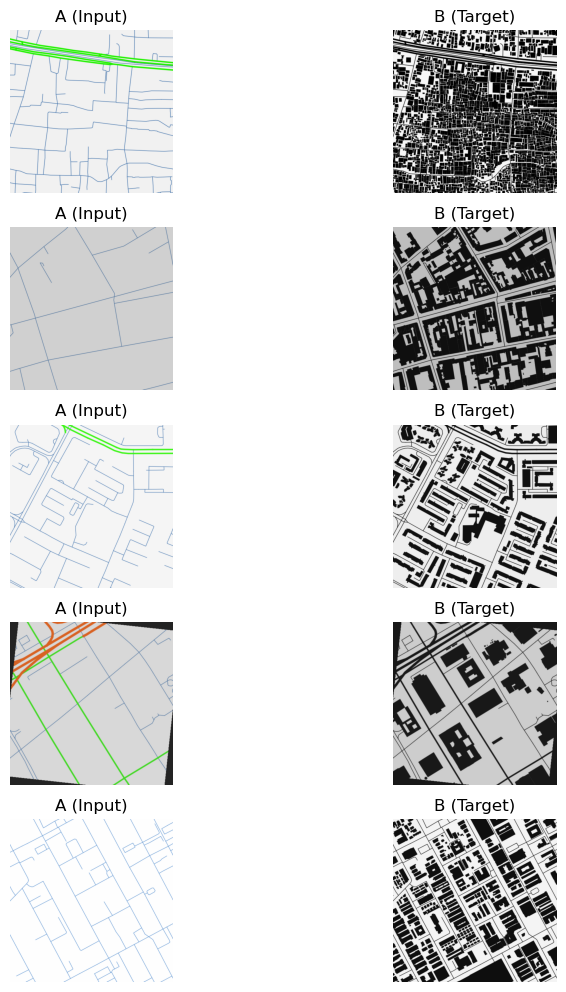

In [63]:
# original image pairs showing

# Train folders
train_A_dir = 'data/train_aug/A'
train_B_dir = 'data/train_aug/B'

# List all images and sort to ensure pairing
A_images = sorted(os.listdir(train_A_dir))
B_images = sorted(os.listdir(train_B_dir))

# Make sure lengths match
assert len(A_images) == len(B_images), "A and B must have the same number of images"

# Randomly sample 5 image indices
sample_indices = random.sample(range(len(A_images)), 5)

plt.figure(figsize=(10, 10))  # enlarge figure
for i, idx in enumerate(sample_indices):
    A_path = os.path.join(train_A_dir, A_images[idx])
    B_path = os.path.join(train_B_dir, B_images[idx])
    
    A_img = Image.open(A_path).convert("RGB")
    
    B_img = Image.open(B_path).convert("RGBA")  # retain alpha
    background = Image.new("RGB", B_img.size, (255, 255, 255))  # white background
    background.paste(B_img, mask=B_img.split()[3])  # masking with alpha
    B_img = background
    
    # Display A
    plt.subplot(5, 2, i*2 + 1)
    plt.imshow(A_img)
    plt.title("A (Input)")
    plt.axis("off")
    
    # Display B
    plt.subplot(5, 2, i*2 + 2)
    plt.imshow(B_img)
    plt.title("B (Target)")
    plt.axis("off")

plt.tight_layout(pad=1.0)
plt.show()

In [70]:
# Transformations

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),          # [0,1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # [-1,1]
])

train_dataset = PairedImageDataset('data/train_aug', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Define model (CondtionalGAN/Pix2Pix style)

In [71]:
# Define Generator (U-Net)

class UNetGenerator(nn.Module):
    # Simple U-Net for demo purposes
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv2d(in_channels, features, 4, 2, 1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(features, features*2, 4, 2, 1), nn.BatchNorm2d(features*2), nn.LeakyReLU(0.2))
        self.down3 = nn.Sequential(nn.Conv2d(features*2, features*4, 4, 2, 1), nn.BatchNorm2d(features*4), nn.LeakyReLU(0.2))
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(features*4, features*2, 4, 2, 1), nn.BatchNorm2d(features*2), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(features*2, features, 4, 2, 1), nn.BatchNorm2d(features), nn.ReLU())
        self.up3 = nn.Sequential(nn.ConvTranspose2d(features, out_channels, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        u1 = self.up1(d3)
        u2 = self.up2(u1 + d2)  # skip connection
        u3 = self.up3(u2 + d1)
        return u3

# Define Discriminator (PatchGAN)
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6, features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features, features*2, 4, 2, 1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features*2, 1, 4, 1, 1)  # output 1-channel patch
        )
    def forward(self, x):
        return self.model(x)

In [81]:
# Initialize networks & optimizers

device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = UNetGenerator().to(device)
D = PatchDiscriminator().to(device)

criterion_GAN = nn.MSELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))

## Train model

In [92]:
def train_GAN(G, D, train_loader, num_epochs=50, log_interval=10,
              save_dir='checkpoints', save_interval=20,
              device=None, lambda_L1=100, lr=0.0002, betas=(0.5,0.999)):
    """
    Train a Pix2Pix GAN model with given Generator and Discriminator.
    Losses, optimizers, and optional model checkpoint saving are handled internally.

    Parameters:
        G (nn.Module)             -- Pre-initialized Generator network
        D (nn.Module)             -- Pre-initialized Discriminator network
        train_loader (DataLoader) -- PyTorch DataLoader providing training data pairs (A, B)
        num_epochs (int)          -- Number of training epochs
        log_interval (int)        -- Steps between printing loss logs
        save_dir (str or None)    -- Directory to save model checkpoints. If None, checkpoints are not saved
        save_interval (int)       -- Save model every `save_interval` epochs
        device (str or None)      -- 'cuda', 'cpu', or None for auto selection 
        lambda_L1 (float)         -- Weight for L1 loss relative to GAN loss
        lr (float)                -- Learning rate for Adam optimizer
        betas (tuple)             -- Beta parameters for Adam optimizer

    Returns:
        G (nn.Module)  -- Trained generator network
        history (dict) -- Dictionary containing lists of discriminator and generator losses:
                          history['loss_D'], history['loss_G']
    """
    
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    history = {'loss_D': [], 'loss_G': []}

    G.to(device)
    D.to(device)
    G.train()
    D.train()

    # --- Loss functions ---
    criterion_GAN = nn.MSELoss()
    criterion_L1 = nn.L1Loss()

    # --- Optimizers ---
    optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
    optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            real_A = data['A'].to(device)
            real_B = data['B'].to(device)

            # --- Train Discriminator ---
            optimizer_D.zero_grad()
            fake_B = G(real_A)
            real_AB = torch.cat([real_A, real_B], 1)
            fake_AB = torch.cat([real_A, fake_B.detach()], 1)

            D_real_out = D(real_AB)
            D_fake_out = D(fake_AB)
            real_label = torch.ones_like(D_real_out)
            fake_label = torch.zeros_like(D_fake_out)

            loss_D_real = criterion_GAN(D_real_out, real_label)
            loss_D_fake = criterion_GAN(D_fake_out, fake_label)
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # --- Train Generator ---
            optimizer_G.zero_grad()
            fake_AB = torch.cat([real_A, fake_B], 1)
            D_fake_out = D(fake_AB)
            real_label_G = torch.ones_like(D_fake_out)

            loss_G_GAN = criterion_GAN(D_fake_out, real_label_G)
            loss_G_L1 = criterion_L1(fake_B, real_B) * lambda_L1
            loss_G = loss_G_GAN + loss_G_L1
            loss_G.backward()
            optimizer_G.step()

            # --- Logging ---
            if i % log_interval == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(train_loader)}] "
                      f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

            history['loss_D'].append(loss_D.item())
            history['loss_G'].append(loss_G.item())

        # --- Save model at intervals ---
        if save_dir is not None and ((epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs):
            torch.save(G.state_dict(), os.path.join(save_dir, f'G_epoch_{epoch+1}.pth'))
            torch.save(D.state_dict(), os.path.join(save_dir, f'D_epoch_{epoch+1}.pth'))
            print(f"Models saved at epoch {epoch+1}")

    return G, history

In [93]:
# Initilize model
G = UNetGenerator()
D = PatchDiscriminator()

# Train model
G_trained, log = train_GAN(G, D, train_loader, num_epochs=50, log_interval=10,
                           save_dir='checkpoints', save_interval=10)

Epoch [1/50] Step [0/39] Loss D: 0.6864, Loss G: 80.6023
Epoch [1/50] Step [10/39] Loss D: 0.2297, Loss G: 68.5271
Epoch [1/50] Step [20/39] Loss D: 0.1543, Loss G: 68.7618
Epoch [1/50] Step [30/39] Loss D: 0.1525, Loss G: 64.7715
Epoch [2/50] Step [0/39] Loss D: 0.1583, Loss G: 60.9603
Epoch [2/50] Step [10/39] Loss D: 0.1725, Loss G: 63.4357
Epoch [2/50] Step [20/39] Loss D: 0.1442, Loss G: 62.2125
Epoch [2/50] Step [30/39] Loss D: 0.1427, Loss G: 61.1049
Epoch [3/50] Step [0/39] Loss D: 0.1474, Loss G: 59.4552
Epoch [3/50] Step [10/39] Loss D: 0.1477, Loss G: 60.0274
Epoch [3/50] Step [20/39] Loss D: 0.1514, Loss G: 60.6968
Epoch [3/50] Step [30/39] Loss D: 0.1385, Loss G: 59.1668
Epoch [4/50] Step [0/39] Loss D: 0.1804, Loss G: 64.3356
Epoch [4/50] Step [10/39] Loss D: 0.1213, Loss G: 58.7052
Epoch [4/50] Step [20/39] Loss D: 0.1394, Loss G: 56.1892
Epoch [4/50] Step [30/39] Loss D: 0.1300, Loss G: 64.3722
Epoch [5/50] Step [0/39] Loss D: 0.1631, Loss G: 59.3945
Epoch [5/50] Step [

## Inference
**Note:** This demo uses a small training set and only a few training epochs, so the generation results are not optimal. The purpose here is solely to illustrate the pipeline. For your own projects, you should choose an appropriate model and fine-tune it according to the size and characteristics of your dataset to achieve better performance. For low-resolution GAN training (e.g., 64×64), dataset of roughly a few thousand to around 10,000 image pairs is typically sufficient to obtain reasonable results.

In [94]:
# Helper function to convert tensor to image
def tensor2img(t):
    t = t.cpu().squeeze(0)
    t = (t + 1) / 2.0  # [-1,1] -> [0,1]
    t = t.permute(1,2,0).numpy()
    t = np.clip(t,0,1)
    t = (t*255).astype(np.uint8)
    return t
    
def inference_gan(G, test_A_dir, results_dir='results/', device=None):
    """
    Run inference with a trained Pix2Pix generator on a folder of test images.

    Parameters:
        G (nn.Module)        -- trained generator
        test_A_dir (str)     -- directory of input images (A)
        results_dir (str)    -- directory to save generated images
        device (str or torch.device, optional) -- 'cuda' or 'cpu'; if None, automatically select

    Returns:
        None (saves images in results_dir)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)

    G.to(device)
    G.eval()
    os.makedirs(results_dir, exist_ok=True)

    # Transform (same as training)
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    # Iterate over test images
    for img_name in sorted(os.listdir(test_A_dir)):
        if not img_name.lower().endswith(('.png','.jpg','.jpeg')):
            continue
        A_path = os.path.join(test_A_dir, img_name)
        A_img = Image.open(A_path).convert("RGB")
        A_tensor = transform(A_img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            fake_B = G(A_tensor)
        
        # Convert to image and save
        fake_B_img = Image.fromarray(tensor2img(fake_B))
        fake_B_img.save(os.path.join(results_dir, img_name))

    print("Inference done! Results saved to", results_dir)
    
    return fake_B_img

In [95]:
test_A_dir = 'data/test/A'
results_dir = 'results/'
os.makedirs(results_dir, exist_ok=True)

fake_B_img = inference_gan(G_trained, test_A_dir, results_dir)

Inference done! Results saved to results/


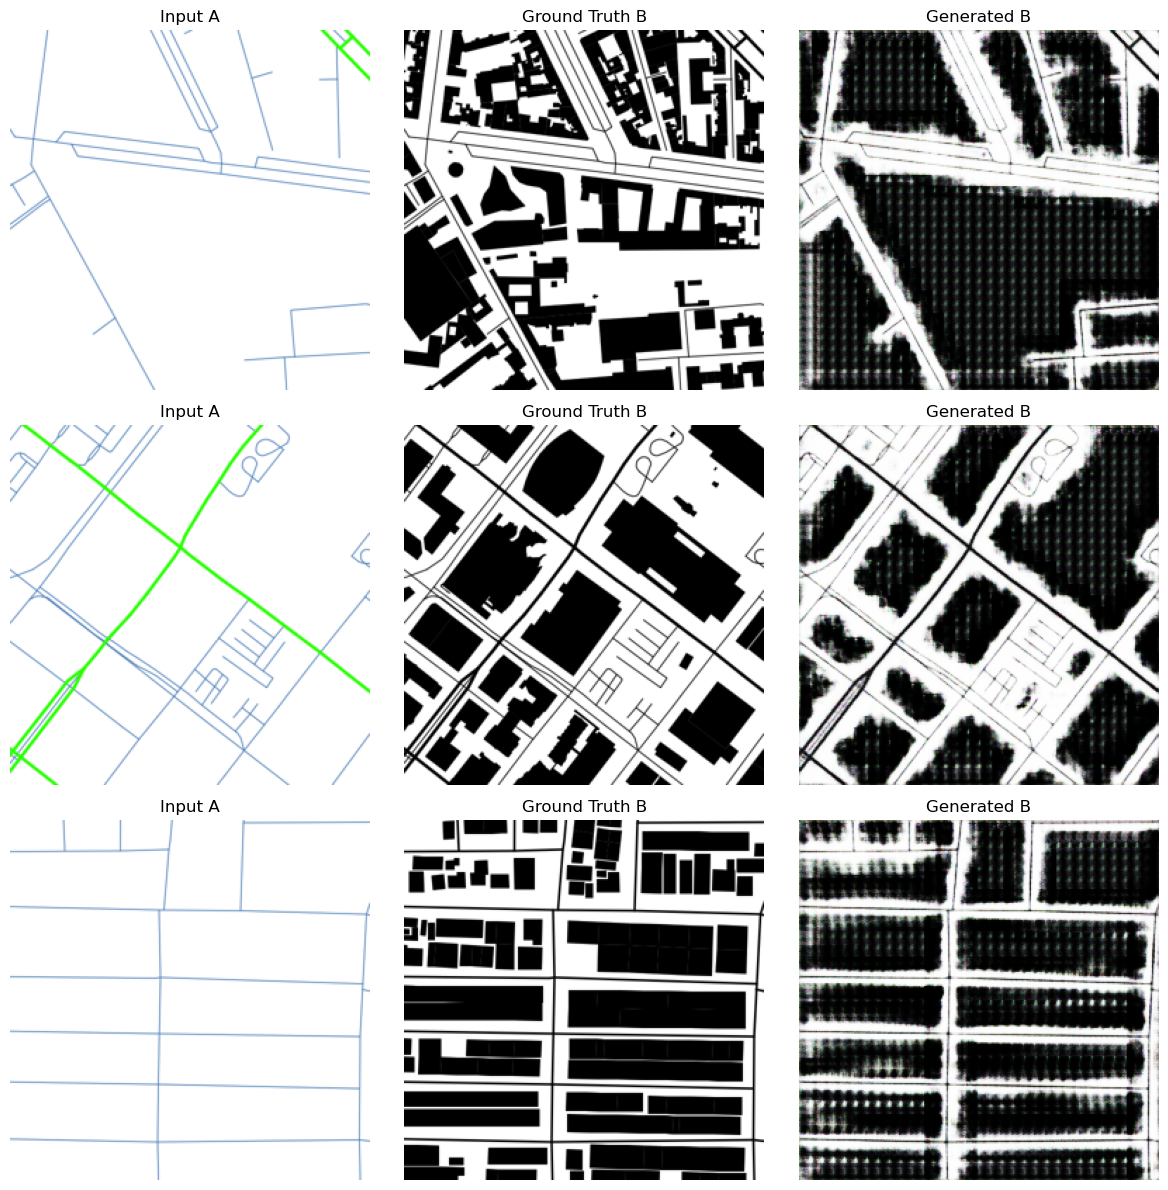

In [96]:
# Directories
test_A_dir = 'data/test/A'
test_B_dir = 'data/test/B'
results_dir = 'results/'

# choose random samples
sample_num = 3
all_test_imgs = sorted(os.listdir(test_A_dir))
sample_imgs = random.sample(all_test_imgs, min(sample_num, len(all_test_imgs)))

fig, axes = plt.subplots(len(sample_imgs), 3, figsize=(12, 4*len(sample_imgs)))

for row, img_name in enumerate(sample_imgs):
    # Paths
    A_path = os.path.join(test_A_dir, img_name)
    B_path = os.path.join(test_B_dir, img_name)
    fake_path = os.path.join(results_dir, img_name)

    # Load images
    A_img = Image.open(A_path).convert("RGB").resize((256,256))
    B_img = Image.open(B_path).convert("RGB").resize((256,256))
    fake_B_img = Image.open(fake_path).convert("RGB").resize((256,256))

    # Plot
    axes[row, 0].imshow(A_img)
    axes[row, 0].set_title("Input A")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(B_img)
    axes[row, 1].set_title("Ground Truth B")
    axes[row, 1].axis("off")

    axes[row, 2].imshow(fake_B_img)
    axes[row, 2].set_title("Generated B")
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()